# Trabajo Práctico 3

Integrantes del grupo:

- Cajachuán Arroyo, Kevin André
- Doffo, Augusto Santiago
- Herrera, Daniel Fernando

Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en Material_TPs/TP3/images a partir del template Material_TPs/TP3/template
1. (4 puntos) Obtener una detección del logo en cada imagen sin falsos positivos
2. (4 puntos) Plantear y validar un algoritmo para múltiples detecciones en la imagen coca_multi.png con el mismo témplate del item 2
3. (2 puntos) Generalizar el algoritmo del item 2 para todas las imágenes.

Visualizar los resultados con bounding boxes en cada imagen mostrando el nivel de confianza de la detección

In [1]:
import os
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [2]:
def get_filenames(dir: str) -> list[str]:
    return list(map(lambda name: f"{dir}/{name}", os.listdir(dir)))

Primero, aplicamos el algoritmo detector de bordes de Canny, para resaltar los contornos del logo y destacar las líneas importantes, e ignorar detalles como el color y textura.

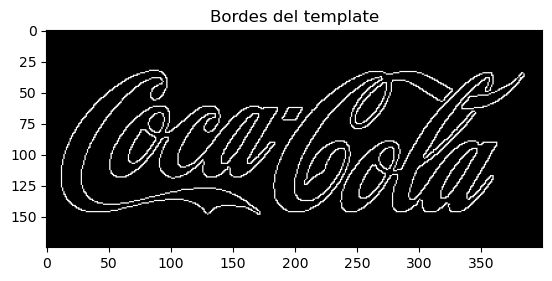

In [3]:
template = cv.imread('template/pattern.png', cv.IMREAD_GRAYSCALE)
template = cv.Canny(template, 120, 240, L2gradient=True)

plt.figure()
plt.imshow(template, cmap='gray')
plt.title("Bordes del template")
plt.show()

## 1. Obtener una detección del logo en cada imagen sin falsos positivos

Se realiza un preprocesamiento, convirtiendo la imagen a escala de grises y se aplica 
el detector de bordes de Canny para resaltar los contornos.

Luego se redimensiona la imagen en diferentes tamaños, para detectar el logo.
Se aplica un algoritmo de Template Matching para comparar el template del logo con la imagen procesada y encontrar las coincidencias.

Finalmente se utilizar cv.minMaxLoc() para encontrar la mejor coincidencia y se dibuja 
un rectángulo verde alrededor de las coincidencias detectadas del logo.

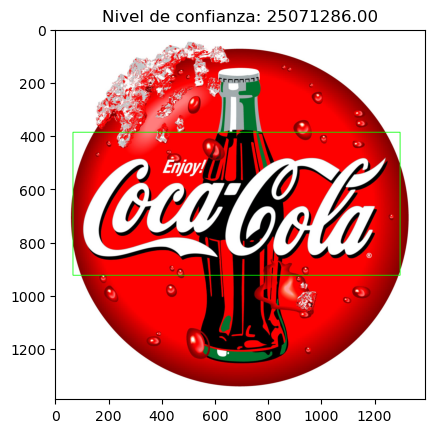

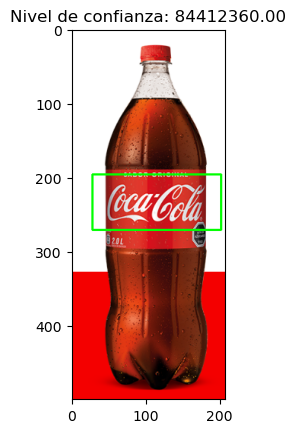

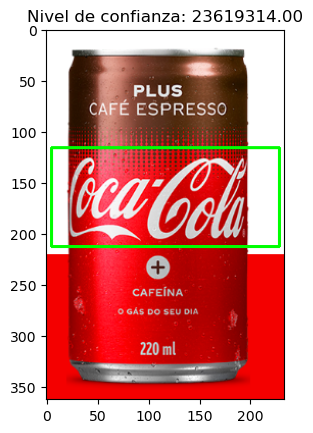

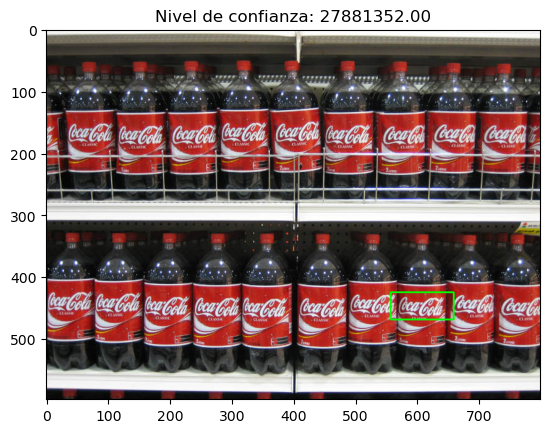

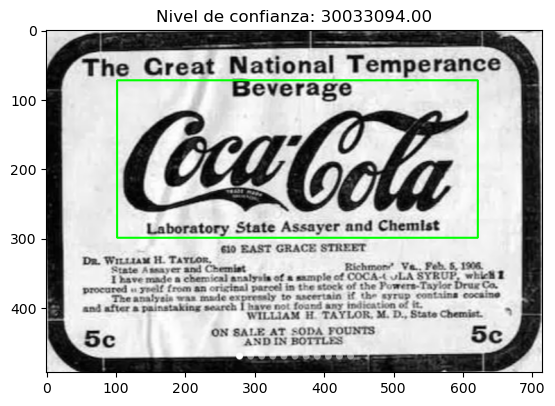

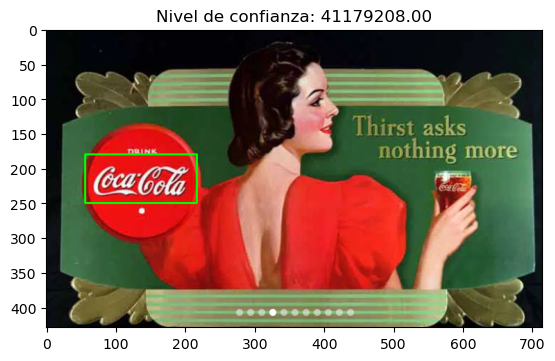

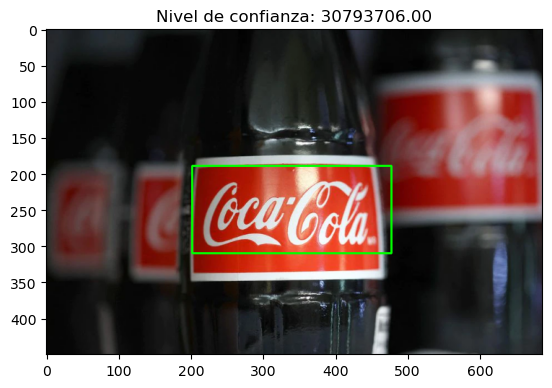

In [4]:
images = get_filenames("images")

for image in images:
    img = cv.imread(image)

    rgb_image = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    gray_image = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    min_scale = max(template.shape[0] / gray_image.shape[0], template.shape[1] / gray_image.shape[1])
    scales = np.linspace(min_scale, 4, 100)

    best_val = -np.inf
    best_loc = 0
    best_scale = 0

    for scale in scales:
        scaled_image = cv.resize(gray_image, (0, 0), fx=scale, fy=scale, interpolation=cv.INTER_LINEAR)
        scaled_edges = cv.Canny(scaled_image, 100, 200, L2gradient=True)

        result = cv.matchTemplate(scaled_edges, template, cv.TM_CCOEFF)
        _, max_val, _, max_loc = cv.minMaxLoc(result)

        if max_val > best_val:
            best_val = max_val
            best_loc = max_loc
            best_scale = scale

    x, y = (np.array(best_loc) / best_scale).astype(int)
    h, w = (np.array(template.shape) / best_scale).astype(int)

    cv.rectangle(rgb_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    plt.figure()
    plt.title(f"Nivel de confianza: {best_val:.2f}")
    plt.imshow(rgb_image)
    plt.show()

## 2. Plantear y validar un algoritmo para múltiples detecciones en la imagen coca_multi.png con el mismo témplate del item 2


Al aplicar el Template Matching, se podría detectar el logo varias veces en áreas cercanas.

Al combinar IoU y supresión de no-máximos (NMS), el algoritmo asegura que solo se muestren las detecciones más relevantes, evitando duplicados en zonas superpuestas.

Se selecciona la mejor detección y el algoritmo compara esta detección con otras detecciones superpuestas usando la métrica IoU, considerando un umbral, y si se considerea redundante, esa detección se elimina.

El proceso se repite hasta que solo quedan las deteccion más relevantes.

In [5]:
def iou(box1, box2):
    # Obtengo las coordenadas de la intersección
    x1_inter = max(box1[0], box2[0])
    y1_inter = max(box1[1], box2[1])
    x2_inter = min(box1[2], box2[2])
    y2_inter = min(box1[3], box2[3])

    # Calculo el área de la intersección
    inter_area = max(0, x2_inter - x1_inter + 1) * max(0, y2_inter - y1_inter + 1)

    # Calculo el área de ambas cajas
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    # Calculo el área de la unión
    union_area = box1_area + box2_area - inter_area

    # Retorno el IoU
    return inter_area / union_area

In [6]:
def get_box_from_point_and_scale_template(point, scale, template_shape):
    x, y = int(point[0] / scale), int(point[1] / scale)
    h, w = int(template_shape[0] / scale), int(template_shape[1] / scale)
    return [x, y, x + w, y + h]

In [7]:
def non_maximum_suppression(points, values, scale, template_shape, iou_threshold):
    indices = np.argsort(values)[::-1]
    keep_points = []

    while len(indices) > 0:
        current_point = points[indices[0]]
        current_box = get_box_from_point_and_scale_template(current_point, scale, template_shape)
        keep_points.append(indices[0])
        remaining_points = points[indices[1:]]

        ious = np.array([
            iou(current_box, get_box_from_point_and_scale_template(point, scale, template_shape)) 
            for point in remaining_points
        ])

        indices = indices[1:][ious < iou_threshold]

    return keep_points

In [8]:
def multi_image_match(image, max_threshold=0.65):
    img = cv.imread(image)

    rgb_image = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    gray_image = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    min_scale = max(template.shape[0] / gray_image.shape[0], template.shape[1] / gray_image.shape[1])
    scales = np.linspace(min_scale, 4, 100)

    best_points = []
    best_values = [-np.inf]
    best_scale = 0

    for scale in scales:
        scaled_image = cv.resize(gray_image, (0, 0), fx=scale, fy=scale, interpolation=cv.INTER_LINEAR)
        scaled_edges = cv.Canny(scaled_image, 100, 200, L2gradient=True)

        result = cv.matchTemplate(scaled_edges, template, cv.TM_CCOEFF)
        locations = np.where(result >= max_threshold * np.max(result))
        values = result[locations]
        points = list(zip(*locations[::-1]))
        if np.max(values) > np.max(best_values):
            best_points = points
            best_values = values
            best_scale = scale

    best_points = np.array(best_points)
    nms_indices = non_maximum_suppression(best_points, best_values, best_scale, template.shape, 0.5)
    nms_indices.sort()
    filtered_best_points = best_points[nms_indices]

    for idx, point in enumerate(filtered_best_points):
        box = get_box_from_point_and_scale_template(point, best_scale, template.shape)
        cv.rectangle(rgb_image, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
        cv.rectangle(rgb_image, (box[0], box[1]), (box[0] + 75, box[1] - 15), (0, 255, 0), cv.FILLED)

        confidence = best_values[nms_indices[idx]]
        cv.putText(rgb_image, f'{confidence:.2f}', (box[0], box[1] - 5), cv.FONT_HERSHEY_SIMPLEX, 0.35, (0, 0, 0), 1)

    plt.figure()
    plt.imshow(rgb_image)
    plt.show()

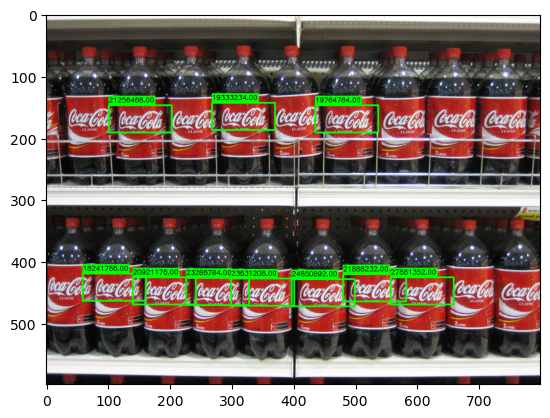

In [9]:
multi_image_match("images/coca_multi.png")

## 3. Generalizar el algoritmo del item 2 para todas las imágenes.

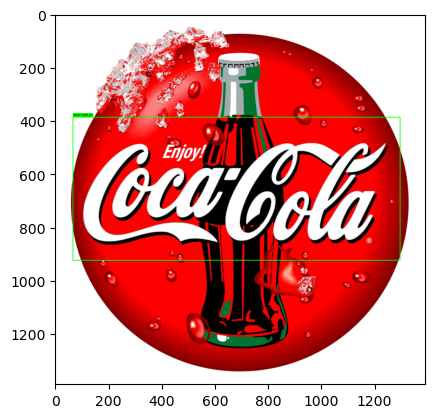

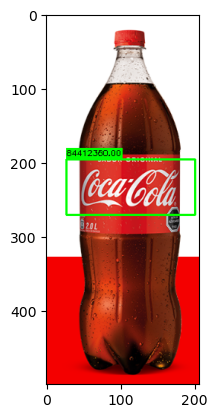

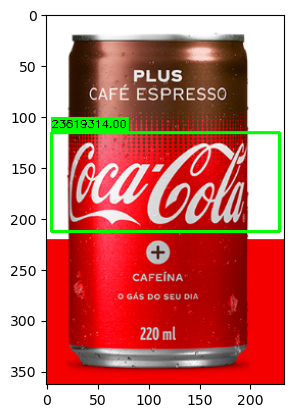

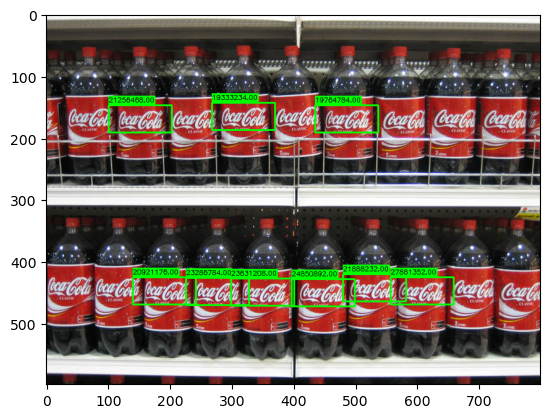

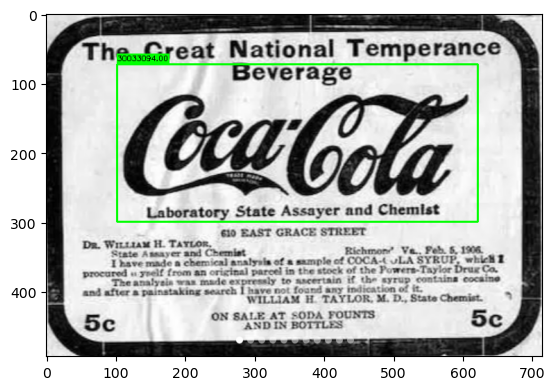

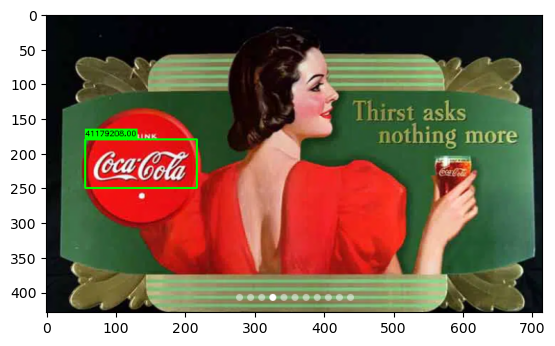

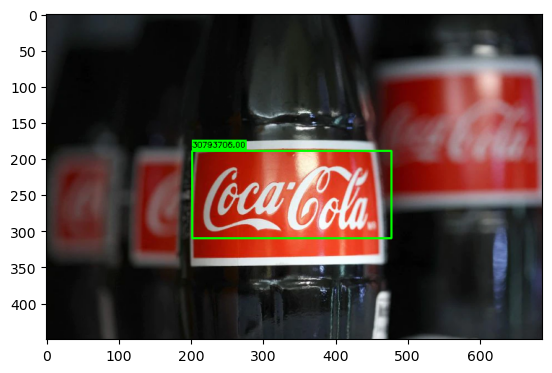

In [10]:
images = get_filenames("images")
for image in images:
    multi_image_match(image, max_threshold=0.69)